In [1]:
%pylab inline
style.use('ggplot')

rc('figure',figsize=(13,8))

rcParams['image.aspect'] = 'equal'

vega_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
               '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

mpl.rcParams['axes.prop_cycle'] = cycler(color=vega_colors)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import itertools as itt

In [55]:
import setup

SystemExit: usage: ipykernel_launcher.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
   or: ipykernel_launcher.py --help [cmd1 cmd2 ...]
   or: ipykernel_launcher.py --help-commands
   or: ipykernel_launcher.py cmd --help

error: option -f not recognized

C:\Users\April\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [56]:
!pip install imfun
import numpy as np
from scipy import stats
from scipy import ndimage as ndi
import pandas
import matplotlib.pyplot as plt

import statsmodels.api as sm

  Could not find a version that satisfies the requirement imfun (from versions: )
No matching distribution found for imfun


In [4]:
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels import tsa

In [5]:
from imfun import core,ui

ModuleNotFoundError: No module named 'imfun'

In [ ]:
from imfun.filt import l1spline, l2spline

In [ ]:
from tqdm import tqdm

In [ ]:
#import μCats as ucats
import ucats

In [6]:
def ar1(alpha = 0.74):
    "Simple auto-regression model"
    randn = np.random.randn
    prev = randn()
    while True:
        res = prev*alpha + randn()
        prev = res
        yield res

        
def ar1_wmean(alpha = 0.74, μ = 10):
    randn = np.random.randn
    prev = μ + randn()
    δ = (1 - alpha)*μ
    while True:
        res = δ +  prev*alpha + randn()
        #res = prev + alpha*(x0-prev) + randn()
        prev = res
        yield res
        
from collections import deque



def ar_process(noise, p, μ=0):
    buff = deque()
    memlen = len(p)
    for i,n in enumerate(noise):
        if i == 0:
            upd = μ + n
        else:
            upd = μ*(1-np.sum(p)) + n + np.sum([phi*b for phi,b in zip(p,buff)])
        buff.appendleft(upd)
        if len(buff)>memlen:
            buff.pop()
            yield upd

def rcar_process1(noise, pnoise, μ=0, baseline_p = 0.95):
    for i,(n,pn) in enumerate(zip(noise,pnoise)):
        if i == 0:
            upd = μ + n
        else:
            upd = (1-baseline_p)*μ + upd*pn + n
        yield upd            
            
def rcar_process(noise, pnoise, μ=0):
    buff = deque()
    
    for i,(n,pn) in enumerate(zip(noise,pnoise)):
        if np.iterable(pn):
            memlen = len(pn)
        else:
            memlen = 1
            pn = (pn,)
        upd = n + np.sum([phi*b for phi,b in zip(pn,buff)]) + (1-np.sum(pn))*μ
        buff.appendleft(upd)
        if len(buff) > memlen:
            buff.pop()
            yield upd
            
def arma_process(noise, phiv, thetav, c=0):
    p,q = len(phiv),len(thetav)
    buff_ar, buff_ma = deque(),deque()
    for i, n in enumerate(noise):
        upd = n 
        upd += np.sum(phi*b for phi,b in zip(phiv,buff_ar))
        upd += np.sum(th*b for th,b in zip(thetav,buff_ma))
        buff_ar.appendleft(upd)
        buff_ma.appendleft(n)
        if len(buff_ma) > q:
            buff_ma.pop()
        if len(buff_ar) > p: 
            buff_ar.pop()
        if i > p and i > q:
            yield(upd+c)

In [7]:
_Ca_rest = 0.075  # uM


In [8]:
L = 1000

ar1_p = ar1(0.95)
process = ar1_wmean(1.0001)

v1 = array(core.fu.take(L,ar1_p))
v2 = core.fu.take(L,process)
mean(10+v1), mean(v2)

NameError: name 'core' is not defined

In [9]:
plot(10+v1)
plot(v2)

NameError: name 'v1' is not defined

### Autoregressive process with mean $\mu$ and coeffiecients $\alpha_i$:

\begin{equation}
x_{n+1} = \mu\left(1 - \sum_i\alpha_i\right) + \sum_i x_{n-i+1}\alpha_i + \xi_n
\end{equation}

## 1D Random coefficient autoregressive processes

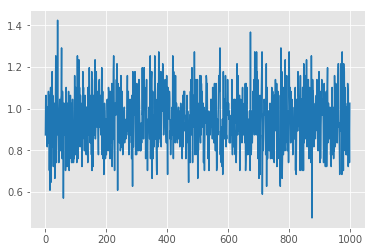

In [10]:
L = 1000
#alpha = 0.1+0.5*randn(1000)**2
alpha = 0.019*poisson(lam=50,size=L)
plot(alpha)

In [11]:
spikes = rand(L) < 0.02

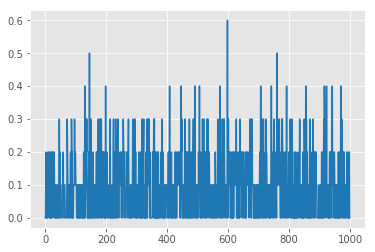

In [12]:
plot(0.1*poisson(size=L))

In [13]:
noise = poisson(size=L)+5*spikes
#alpha = 0.5+0.0075*poisson(lam=50,size=L)
alpha = rand(L)<0.1
x = rcar_process(noise,alpha)

In [14]:
v = core.fu.take(L-10,x)

NameError: name 'core' is not defined

NameError: name 'v' is not defined

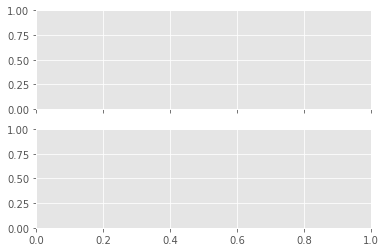

In [15]:
f,axs = subplots(2,1,sharex=True)

axs[0].plot(v)
axs[0].plot(noise,c='r')
axs[1].plot(alpha,c='y')
axs[1].axhline(mean(alpha),c='g')
#gcf()

In [16]:
from scipy import ndimage

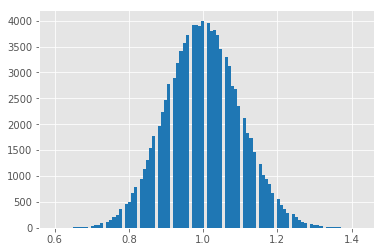

In [17]:
_ = hist(0.01*poisson(lam=100,size=100000),100)

In [18]:
%matplotlib qt

## Autoregressive process with Markov switching coefficient

### Constant transition rates

In [19]:
# тут задаётся функция выбирающая случайные значения из массива со значениями количества элементов объекта "Transition_rates"
def markov_states(init_state, transition_rates):
    nstates = len(transition_rates)
    avail_states = np.arange(nstates,dtype=np.int)
    state = init_state
    while True:
        new_state = np.random.choice(avail_states, p = transition_rates[state])#новое состояние - случайный выбор как раз
        yield new_state
        state = new_state

Let's look at a simple case of 3-state switching. 

State 0: "resting", state 1: "active", state 2: 'inactive'

Transition probabilities (for example):
   - 0 &rightarrow; 1: 0.01
   - 1 &rightarrow; 0: 0.1
   - 1 &rightarrow; 2: 0.2
   - 2 &rightarrow; 0: 0.01

In [20]:

tmap = np.array([[0.98, 0.01, 0],
                 [0.1, 0.7, 0.15],
                 [0.02, 0, 0.98]])
tmap = tmap/ np.sum(tmap, axis=1)[:,None] # ensure probabilitites
tmap

array([[0.98989899, 0.01010101, 0.        ],
       [0.10526316, 0.73684211, 0.15789474],
       [0.02      , 0.        , 0.98      ]])

In [21]:
mx = markov_states(0, tmap)

In [22]:
N = 40000

In [23]:
def take(N, seq,step=1):
    "Takes first N values from a sequence"
    return list(itt.islice(seq, 0, N, step))

In [24]:
%time x = fromiter(mx, int, N)

Wall time: 985 ms


In [25]:
#IP3R_model.ode
# parameter values
par nip3r = 1000
par alpha=1.0
par beta=0.01
par gamma=50
par nplc=1e3
par delta=0.10
par a1=1
par b1=0.1
# in this code, a2 and b2 correspond to a3 and b3 from the paper: binding and unbinding constants for Ca second site.
par a2=0.10
par b2=0.10
# in this code, a3 and b3 correspond to a2 and b2 from the paper: binding and unbinding constants for IP3 site.
par a3=1.0
par b3=0.1
par mu=50
par V=4e4

#IP3 pulse amplitude, from 0 to 100 IP3 molecules
par pulsamp=50
#IP3 pulse first infusion
par pulst0=20
#IP3 pulse duration
par pulsdur=1


# ODEs
x111=nip3r-(x000+x010+x100+x110+x001+x011+x101)
dCa/dt=-alpha*Ca+gamma- a1/V*Ca*(x000+x010+x001+x011)-a2/V*Ca*(x000+x100+x001+x101)+b1*(x100+x110+x101+x111)+b2*(x010+x110+x011+x111)+mu*x101
dIP3/dt=pulsamp*f(t)+delta/V*nplc*Ca-beta*IP3-a3/V*IP3*(x000+x010+x100+x110)+b3*(x001+x101+x011+x111)
dx000/dt=-(a1/V*Ca+a2/V*Ca+a3/V*IP3)*x000+b1*x100+b2*x010+b3*x001
dx010/dt=-(a1/V*Ca+b2+a3/V*IP3)*x010+b1*x110+a2/V*Ca*x000+b3*x011
dx100/dt=-(b1+a2/V*Ca+a3/V*IP3)*x100+a1/V*Ca*x000+b2*x110+b3*x101
dx110/dt=-(b1+b2+a3/V*IP3)*x110+a1/V*Ca*x010+a2/V*Ca*x100+b3*x111
dx001/dt=-(a1/V*Ca+a2/V*Ca+b3)*x001+b1*x101+b2*x011+a3/V*IP3*x000
dx011/dt=-(a1/V*Ca+b2+b3)*x011+b1*x111+a2/V*Ca*x001+a3/V*IP3*x010
dx101/dt=-(b1+a2/V*Ca+b3)*x101+a1/V*Ca*x001+b2*x111+a3/V*IP3*x100


f(t)=heav(pulst0+pulsdur-t)*heav(t-pulst0)
aux.IP3inj=pulsamp*f(t)

# Set initial conditions
init Ca=50, x000=1e3, x010=0, x100=0,x110=0 
init x001=0,x011=0,x101=0, IP3=15

@ total=2000,dt=0.1,meth=rk4,bounds=1e4
@ maxstore=10000000

done

SyntaxError: invalid syntax (<ipython-input-25-7e218b108216>, line 3)

In [26]:
import random as rnd
#gillespie_functions
"""
define propensities method
input: vector storing state at time t of all species (including the 3 binding sites of all IP3R molecules) , parameters
output: propensities array																	
"""

def propensities(vec, p):
    ai = np.zeros(p.nb_reactions)
    ca = vec[0] # get number of ca and IP3 from vec
    ip3 = vec[1]
    idx_ca1 = 2 + 3 * np.arange(0, p.nIP3R) # set indexes that represent state of each binding site (ca1, ip3 and ca2) of each IP3R
    idx_ip3 = 3 + 3 * np.arange(0, p.nIP3R)
    idx_ca2 = 4 + 3 * np.arange(0, p.nIP3R)
    ncc = vec[idx_ca1] * vec[idx_ip3] * (1 - vec[idx_ca2])# compute vector of each IP3R state (1.0 if open, 0 if closed): ca1 and IP3 bound ca2 unbound 
    nca1 = np.sum(vec[idx_ca1]) # compute number of bound sites for each type of binding site (ca1, ip3 and ca2) from all IP3Rs
    nca2 = np.sum(vec[idx_ca2])
    nip3 = np.sum(vec[idx_ip3])
    rnc  = np.sum(ncc) # get number of open IP3R: sum of IP3R state vector (equals 1.0 if open)
    ai[0] =  p.nIP3R * p.gamma #first compute propensity for IP3R-independent ca influx
    ai[1] =  p.mu * rnc # compute propensity for ca flux through open IP3R
    ai[2] =  p.alpha * ca  # compute propensity for ca decay  
    ai[3] =  p.nplc * ca * p.delta / p.volume # compute propensity for ip3 synthesis via Ca-dependent PLC activity
    ai[4] =  p.beta * ip3 # compute propensity for ip3 decay
    rx = np.arange(p.nIP3R) # for remaining columns (index 5 to len(ai)), compute propensity for IP3R sites binding/unbinding
    ai[5 + 2 * (3 * rx + 0) + 0] =  p.a1 * ca * (1 - vec[2 + 3*rx + 0]) / p.volume # compute propensity for ca1 sites binding to Ca
    ai[5 + 2 * (3 * rx + 0) + 1] =  p.b1 * vec[2 + 3*rx + 0] # compute propensity for ca1 sites unbinding from Ca
    ai[5 + 2 * (3 * rx + 1) + 0] =  p.a2 * ip3 * (1 - vec[2 + 3*rx + 1]) / p.volume # compute propensity for ip3 sites binding to IP3
    ai[5 + 2 * (3 * rx + 1) + 1] =  p.b2 * vec[2 + 3*rx + 1] # compute propensity for ip3 sites unbinding from IP3
    ai[5 + 2 * (3 * rx + 2) + 0] =  p.a3 * ca * (1 - vec[2 + 3*rx + 2]) / p.volume # compute propensity for ca2 sites binding to Ca
    ai[5 + 2 * (3 * rx + 2) + 1] =  p.b3 * vec[2 + 3*rx + 2] # compute propensity for ca2 sites unbinding from Ca
    return ai


"""
define compute_gillespie method
input: vector storing state at time t of all species (including all binding sites), array with signs of reactions (sm), parameters
output: next time, vector storing state at time t+next_t of all species
"""
def compute_gillespie(vec, sm, p):
	#compute propensities
        ai = propensities(vec, p)
	# sum all propensities (ca IP3R1_ca1 IP3R2_ip3 IP3R3_ca2 ......... IP3Rn_ca1 IP3Rn_ip3 IP3Rn_ca2 ip3)
        a = np.sum(ai)
	#pick randomly time for next reaction
        next_t = - np.log(random.random()) / a 
	# pick randomly next reaction
        reaction = random.choice(p.nb_reactions, p = ai/a)
        probs=ai/a
        new_vec = vec
        new_vec +=  sm[reaction, :]
        return next_t, new_vec


In [27]:
#calcium_gillespie
import numpy as np
import sys
from draft import compute_gillespie, propensities
import random

alpha = 1.0
gamma = 0.05
# a1 and b1 -> ca first site
a1 = 1.0
b1 = 0.1
# a2 & b2 -> ip3 site
a2 =1.0
b2 = 0.1
# a3 and b3 -> ca second site
a3 = 0.1
b3 = 0.1
delta = 0.1
beta = 0.01

#sid = int(sys.argv[1])
#np.random.seed(sid)
nx = 200.0
ny = 200.0
size = 1
volume = (nx * ny)/size

mu=50
nplc = 1000

### Set parameter values

nIP3R = 1000
nb_reactions = 5 + 2 * 3 * nIP3R
nb_states = 2 + 3 * nIP3R

class param(object):
    def __init__(self,volume, mu, alpha, nIP3R, gamma, a1, b1, a2, b2, a3, b3, nplc, delta, beta, nb_reactions):
        self.a1 = a1
        self.b1 = b1
        self.a2 = a2
        self.b2 = b2
        self.a3 = a3
        self.b3 = b3
        self.nplc = nplc
        self.delta = delta
        self.beta = beta
        self.mu = mu
        self.alpha = alpha
        self.nIP3R = nIP3R
        self.gamma = gamma
        self.volume = volume
        self.nb_reactions = nb_reactions


#defining gillespie parameters (number of reactions and number of states + all parameters of model)
#nb_reactions = 5 + 2 * 3 * nIP3R
#nb_states = 2 + 3 * nIP3R

p = param(volume, mu, alpha, nIP3R, gamma, a1, b1, a2, b2, a3, b3, nplc, delta, beta, nb_reactions)


### INITIALIZATION
t= 0.0
total_time = 10000
ca0 = 50
ip0 = 15

#initialization of a vector that stores # ca, # ip3, state of first ca (ca1) site #1, state of ip3 site #1, state of second ca (ca2) site #1,
# ca1_#2, ip3_#2, ca2_#2, ..., ca1_#n, ip3_#n, ca2_#n 
vec = np.zeros(2 + 3 * nIP3R)
vec[0] = ca0
vec[1] = ip0

"""
initialize matrix sm that represents if reaction will increase or decrease nb of elements in a given state
	columns: ca IP3 IP3R1_ca1 IP3R2_ip3 IP3R3_ca2 ......... IP3Rn_ca1 IP3Rn_ip3 IP3Rn_ca2
	lines: leak mu alpha IP3S_plc Ir a1 b1 a2 b2 a3 b3 .... nIP3R times
	       ca      ip3      IP3R1_ca1   IP3R1_ip3  IP3R2_ca2 .... IP3Rn_ca1  IP3Rn_ip3  IP3Rn_ca2  
leak		1	0	0									
mu		1	0	0									
alpha		-1	0	0
IP3s+plc	0	1	0										
Ir		0	-1	0									
a1		0	0	1									
b1		0	0	-1									
a2		0	0	0									
b2		0	0	0									
a3		0	0	0									
b3		0	0	0	
"""
sm = np.zeros((nb_reactions, nb_states))
# nb ca evolves positively with leak and mu and negatively with alpha
sm[0, 0] = 1.0
sm[1, 0] = 1.0
sm[2, 0] = -1.0
#IP3 synthesis (IP3s and plc activation) term
sm[3, 1] = 1.0
#ip3 degradation term
sm[4, 1] = -1.0

#set signs of reactions for all receptor sites (3*nIP3R)
for r in range(nIP3R):
    for site in range(3):
        sm[5 + 2 * (3 * r + site) + 0, 2 + 3 * r + site] =  1.0
        sm[5 + 2 * (3 * r + site) + 1, 2 + 3 * r + site] = -1.0

###COMPUTE GILLESPIE
while t < total_time:
    next_t, new_vec = compute_gillespie(vec, sm, p)
    t += next_t
    vec = new_vec
    #set indexes of states of each type of IP3R binding site
    idx_ca1 = 2 + 3 * np.arange(0, nIP3R)
    idx_ip3 = 3 + 3 * np.arange(0, nIP3R)
    idx_ca2 = 4 + 3 * np.arange(0, nIP3R)
    # get vector of each IP3R (equals 1.0 if open, 0 if closed): first Ca and IP3 bound (state=1.0) and second Ca unbound (state=0)
    ncc = vec[idx_ca1] * vec[idx_ip3] * (1 - vec[idx_ca2])
    # same method, number of first Ca sites that are bound, same for IP3 and second Ca sites
    nca1 = np.sum(vec[idx_ca1])
    nca2 = np.sum(vec[idx_ca2])
    nip3 = np.sum(vec[idx_ip3])

    # get number of open IP3R: sum of IP3R state vector (equals 1.0 if open)
    rnc  = np.sum(ncc)
  


Populating the interactive namespace from numpy and matplotlib


C:\Users\April\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'take']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [28]:
def state_to_coef(state, active=1.2, resting=0.75):
    return where(state == 1, active, resting)

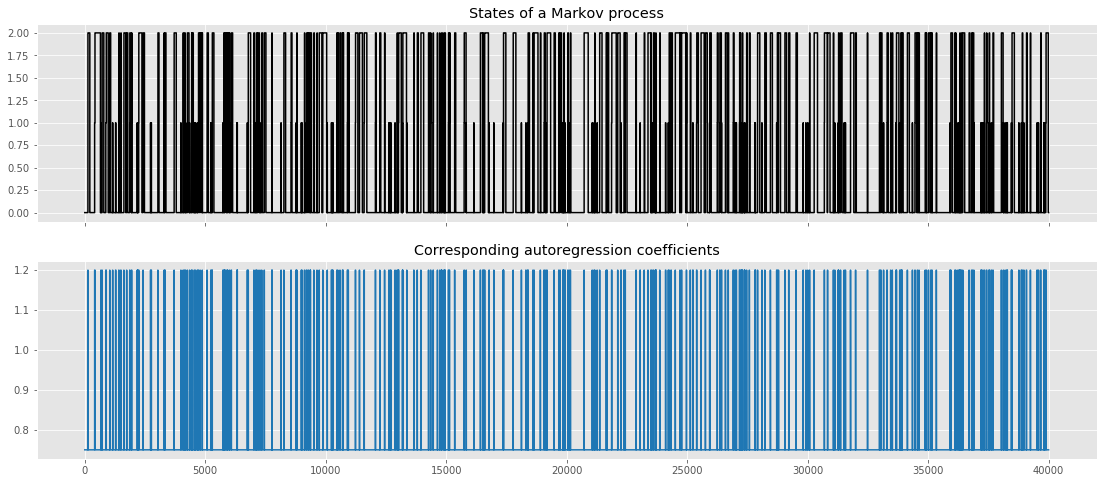

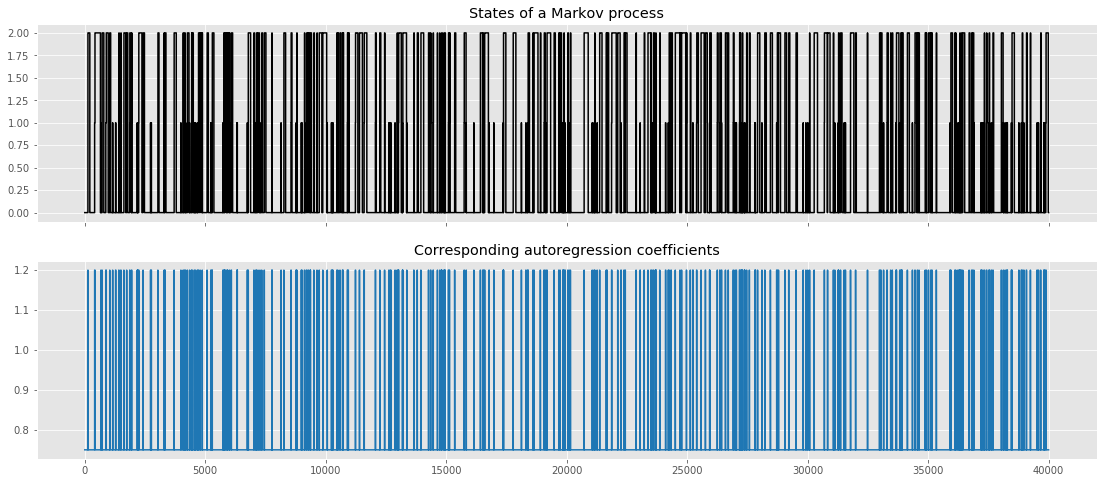

In [29]:
f, axs = subplots(2,1,sharex=True, figsize=(19,8))
axs[0].set_title('States of a Markov process')
axs[0].plot(x, 'k', drawstyle='steps')

axs[1].set_title('Corresponding autoregression coefficients')
axs[1].plot(state_to_coef(x), drawstyle='steps')

f

Now let's use this as an input to random coefficient autoregressive (RCAR) process:

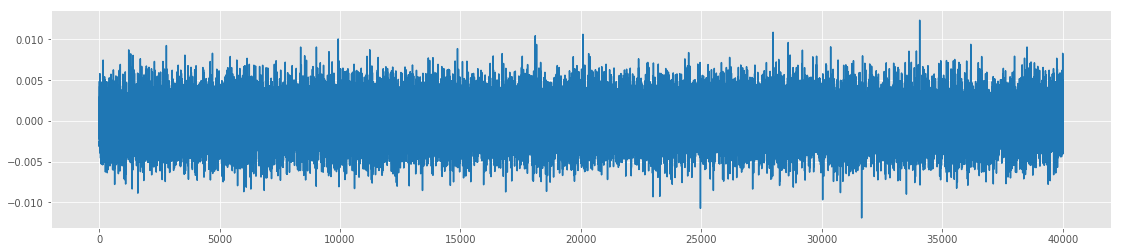

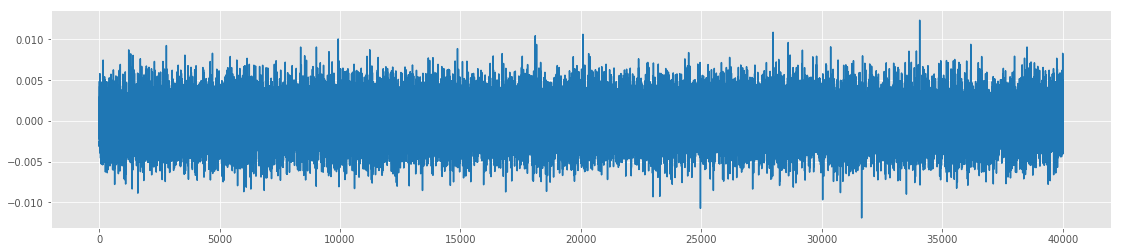

In [30]:
#input_noise = maximum(0.025*randn(len(x)+10),0)
input_noise  =  0.000 + 0.0025*randn(len(x) + 10)
#lam = 0.5
#input_noise = _Ca_rest + poisson(lam=lam, size=len(x)+10)/200
figure(figsize=(19,4))
plot(input_noise)
#ylim(0, 0.15)
gcf()

In [34]:
#mcx = rcar_process1(input_noise, state_to_coef(x), μ=_Ca_rest,baseline_p=0.9)
mcx = rcar_process1(input_noise, ncc, μ=_Ca_rest,baseline_p=0.9)


In [36]:
#%time v = take(len(x), mcx)
%time v = np.fromiter(mcx, float)

Wall time: 997 µs


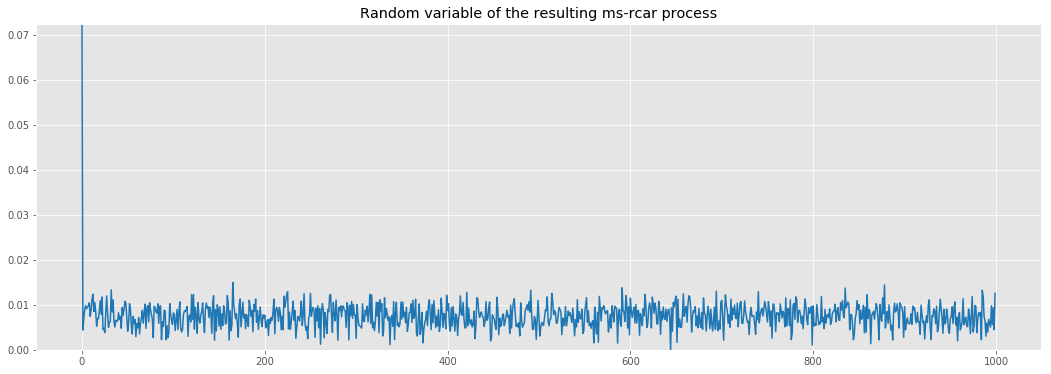

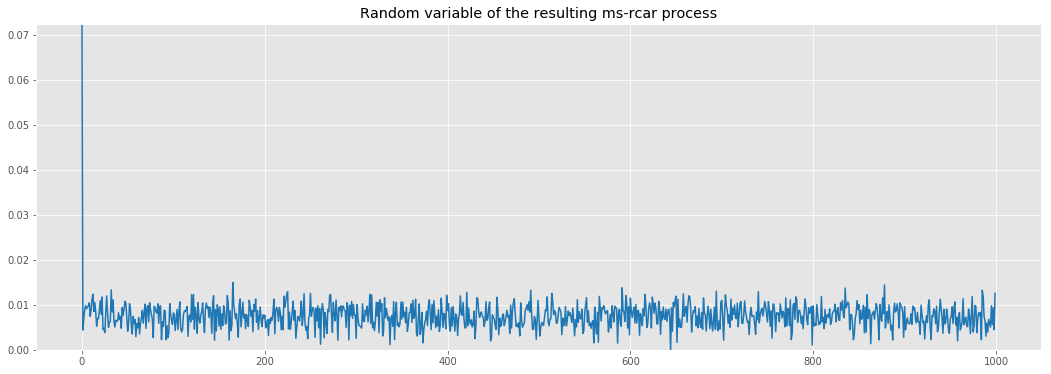

In [37]:
figure(figsize=(18,6))
plot(v)
title('Random variable of the resulting ms-rcar process')
ylim(0, max(v))
gcf()

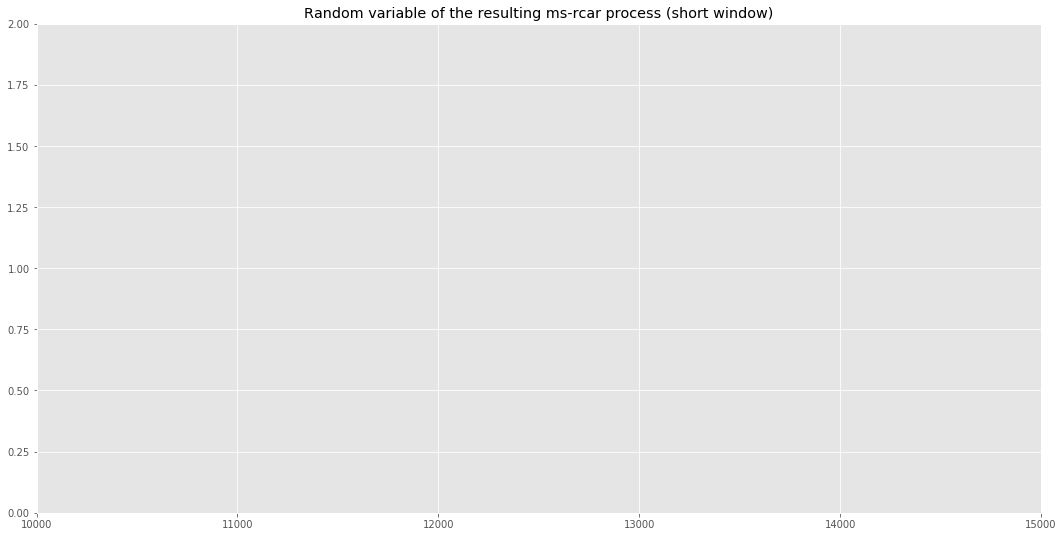

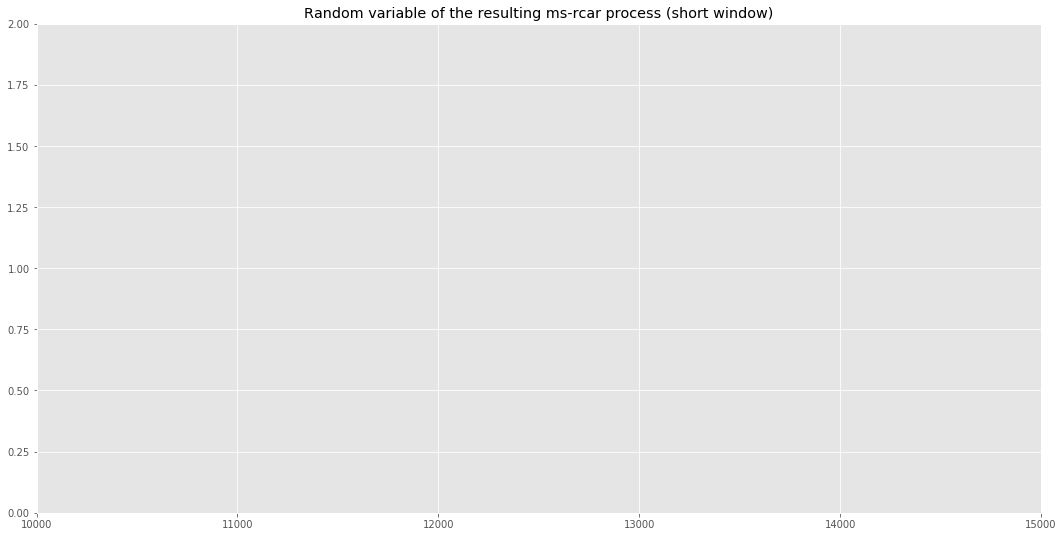

In [39]:
figure(figsize=(18,9))
plot(v)
title('Random variable of the resulting ms-rcar process (short window)')
ylim(0, 2)
xlim(10000,15000)
gcf()

One can see spontaneous spikes over large range of amplitudes. **It would be interesting to calculate Hurst exponent and multifractal spectra of such random process**.

In [514]:
close('all')

In [515]:
#th = percentile(randn(100000)*0.025, 99)
#th, 0.025*3.3

In [516]:
import ucats

In [517]:
th = median(v) + 3*ucats.mad_std(v)
th

0.043655114933735126

AttributeError: Unknown property ds

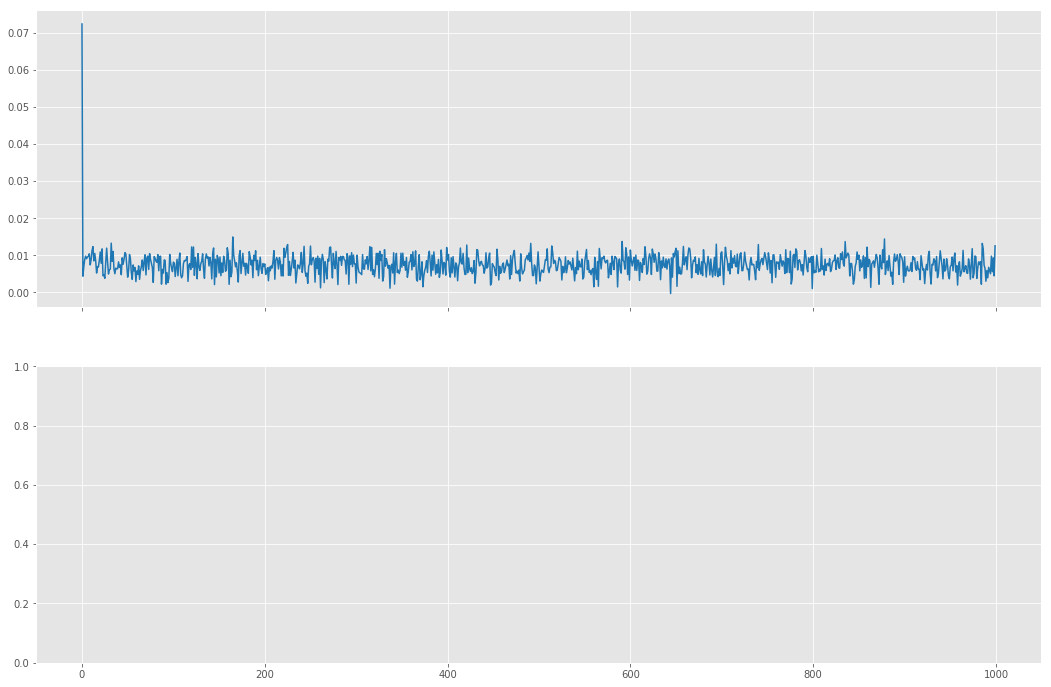

In [40]:
f,axs = subplots(2,1,sharex=True, figsize=(18,12))

axs[0].plot(v)
axs[1].plot(x, ds='steps')
axs[1].plot(x==1,ds='steps')
axs[0].axhline(th, color='gray')
f

In [44]:
from imfun.core import extrema
import powerlaw

ModuleNotFoundError: No module named 'imfun'

In [43]:
peaks = list(filter(lambda x: x[1] > th, extrema.locextr(v, refine=False, output='max')))
peaks = array(peaks)

NameError: name 'extrema' is not defined

In [521]:
len(peaks)

285

In [42]:

figure(); 
hist(peaks[:,1], 200, log=True, density=True, histtype='step');
gcf()

NameError: name 'peaks' is not defined

<Figure size 432x288 with 0 Axes>

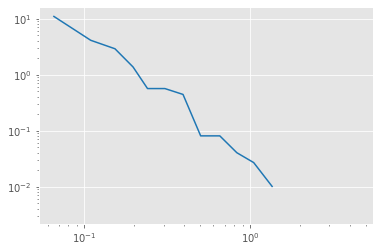

In [523]:
figure();
powerlaw.plot_pdf(peaks[:,1])
gcf()

In [524]:
y = lognormal(10, size=N)

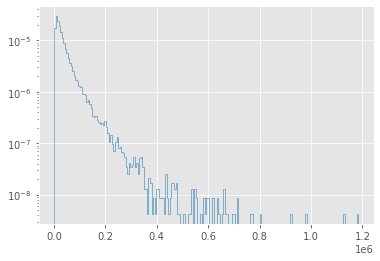

In [525]:

figure(); 
hist(y, 200, log=True, density=True, histtype='step');
gcf()

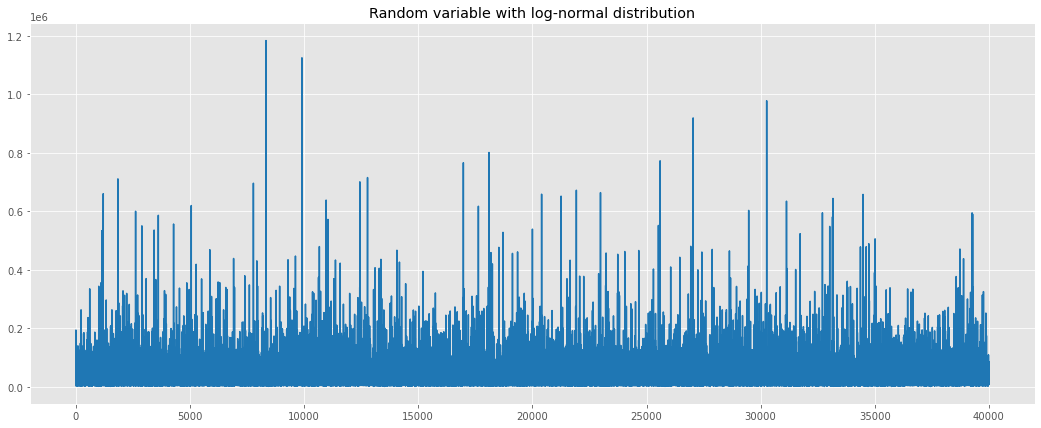

In [526]:

figure(figsize=(18,7));
plot(y)
title('Random variable with log-normal distribution')
gcf()

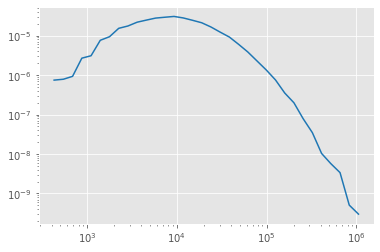

In [527]:
figure();
powerlaw.plot_pdf(y)
gcf()

The resulting distribution of spikes is not log-normal (neither it is exponential, btw)

In [528]:
close('all')

Expected fluorescence is basically another layer of autoregression (or equivalently, convolution with an exponential kernel)

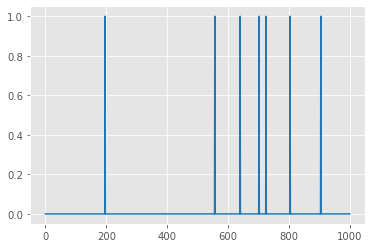

In [529]:
simple_spikes = np.zeros(1000)
simple_spikes[rand(len(simple_spikes))>0.99] = 1

figure();
plot(simple_spikes)
gcf()

In [530]:
next(ar_process(simple_spikes**γ, [0.98]))

0.0

$$
dF/dt = -\beta F + \sum_j\delta(t-t_j)S
$$


In [531]:
γ = 1.0

fluo = list(ar_process(simple_spikes**γ, [0.75]))


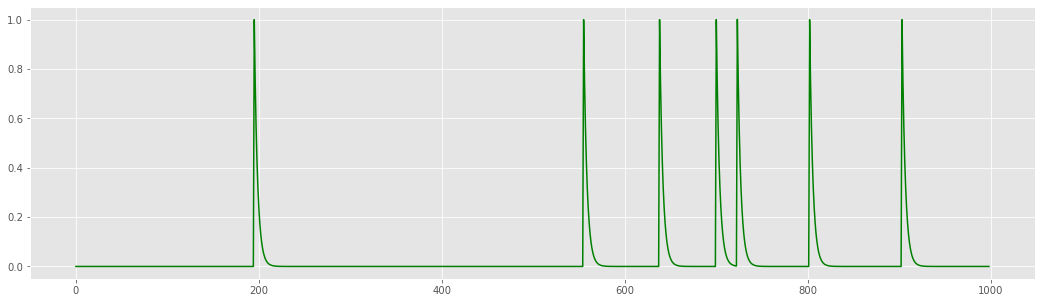

In [544]:
figure(figsize=(18,5))
plot(fluo, 'g')
gcf()

In [601]:
import continuous_poisson as cpoisson

In [602]:
γ = 1.5
fluov  = fromiter(ar_process(v**γ, [0.99]), float)
fluo_noisy = cpoisson.smooth_poisson_its_3d(1*fluov)

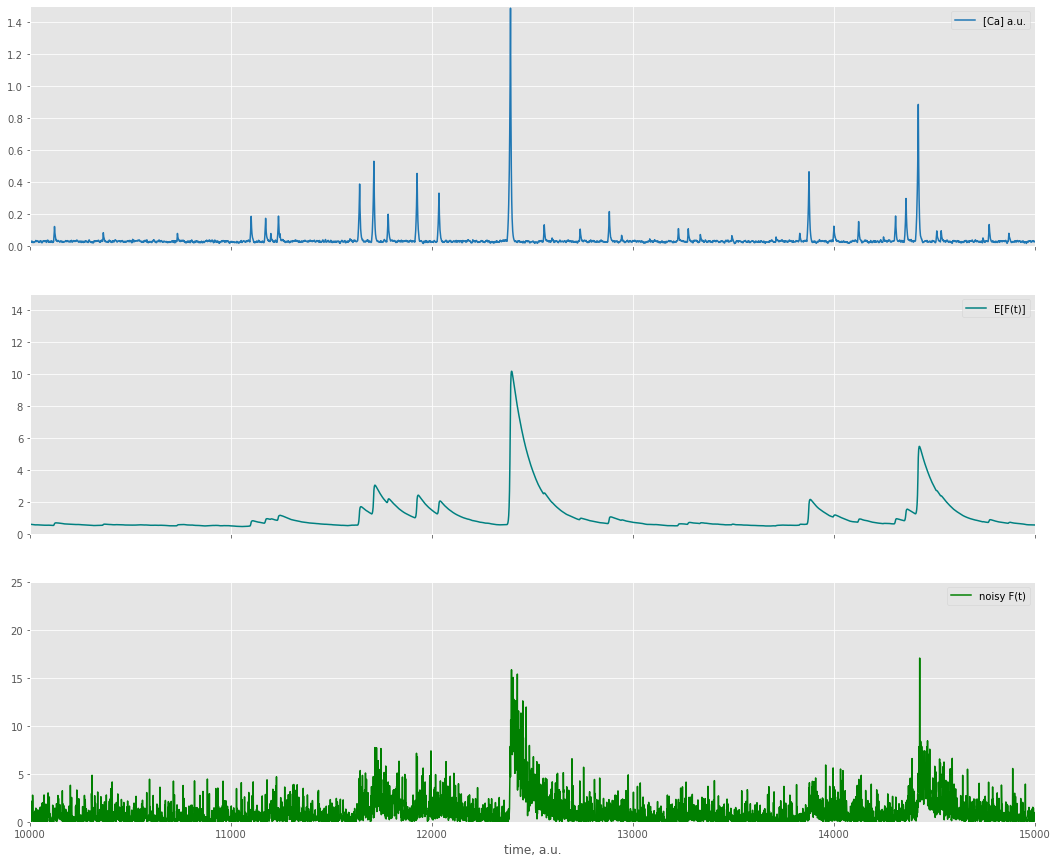

In [603]:
f,axs = subplots(3,1,sharex=True, figsize=(18,15))
axs[0].plot(v, label='[Ca] a.u.')
axs[1].plot(fluov, 'teal',label='E[F(t)]')
axs[2].plot(fluo_noisy, 'g',label='noisy F(t)')

for ax in axs:
    ax.legend()
    
xlim(10e3,15e3)
axs[0].set_ylim(0,1.5)
axs[1].set_ylim(0,15)
axs[2].set_ylim(0,25)

xlabel('time, a.u.')

gcf()

In [599]:
close('all')

### State-dependent transition rates

Now let's acknowledge that activation and inactivation rates can be state-dependent

In [24]:
def boltzmann(x, xhalf=5, k=1):
    return 1/(1 + exp((xhalf-x)/k))

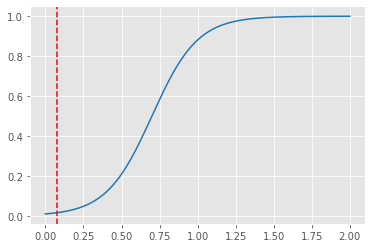

In [25]:
_Ca_rest = 0.075  # uM


x = linspace(0, 2, 200)
plot(x, boltzmann(x, 0.7,0.15))
axvline(_Ca_rest, ls='--',color='r')
gcf()

In [ ]:
powe

In [331]:
close('all')

In [24]:
def boltzmann(x, xhalf=5, k=1):
    return 1/(1 + exp((xhalf-x)/k))

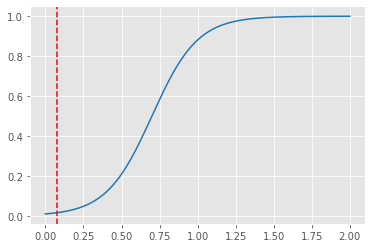

In [25]:
_Ca_rest = 0.075  # uM


x = linspace(0, 2, 200)
plot(x, boltzmann(x, 0.7,0.15))
axvline(_Ca_rest, ls='--',color='r')
gcf()